# Data Analytic Tool/Package Used

Below are the basic libraries used for data analytics.

In [3]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math

For visualization of the information extracted from data, the libraries in below are used. The Python Shapefile Library (pyshp) was used for read and write support of the ESRI Shapefile format. 

Matplotlib was used to produce publication quality figures in a variety of hardcopy formats and interactive environments across platforms.


In [2]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Dataset

The information and download links of NYC Taxi Data can be found in the link below:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Here we use Python code to download data from January 2019 to December 2019 for "Yellow Taxi", "Green Taxi", "FHV" and "FHVHV".

Because of the unusual disruption in social activities in 2020, I decided to use data from 2019 to evaluate 'normal' level of activties. Here, we will closely examine our data from "Yellow Taxi" and "FHVHV" for Uber Air's case. ("Green Taxi" and "FHV" are not as relevant.)  


In [22]:
# Download the Trip Record Data
for month in range(2,13):
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+ \
                               "fhvhv_tripdata_2019-{0:0=2d}.csv".format(month), 
                               "fhvhv_nyc.2019-{0:0=2d}.csv".format(month))



# Ran this for each groups: fhv, fhvhv, green_taxi, yellow_taxi


In [ ]:
# Download the location Data
urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", "taxi_zones.zip")
with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./shape")

## Trip Record

The yellow taxi trip records include fields capturing:

- Vendor ID
- pick-up and drop-off dates/times
- pick-up and drop-off locations
- trip_distance
- passenger count
- itemized fares
- rate types
- payment types


In [27]:
df = pd.read_csv("data/yellow_taxi/yellow_nyc.2019-07.csv", nrows=10)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2,2019-07-01 00:51:04,2019-07-01 00:51:33,1,0.00,1,N,193,193,1,2.5,0.5,0.5,1.14,0.00,0.3,4.94,0.0
1,2,2019-07-01 00:46:04,2019-07-01 01:05:46,1,4.16,1,N,234,25,2,16.5,0.5,0.5,0.00,0.00,0.3,20.30,2.5
2,1,2019-07-01 00:25:09,2019-07-01 01:00:56,1,18.80,2,N,132,42,1,52.0,0.0,0.5,11.75,6.12,0.3,70.67,0.0
3,2,2019-07-01 00:33:32,2019-07-01 01:15:27,1,18.46,2,N,132,142,1,52.0,0.0,0.5,11.06,0.00,0.3,66.36,2.5
4,1,2019-07-01 00:00:55,2019-07-01 00:13:05,0,1.70,1,N,107,114,1,9.5,3.0,0.5,2.00,0.00,0.3,15.30,2.5


In [35]:
df = pd.read_csv("data/fhvhv/fhvhv_nyc.2019-07.csv", nrows=10)
df.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,HV0003,B02884,2019-07-01 00:12:33,2019-07-01 00:25:00,228,89,NaN
1,HV0003,B02884,2019-07-01 00:41:26,2019-07-01 00:51:21,97,188,NaN
2,HV0003,B02870,2019-07-01 00:18:50,2019-07-01 00:32:48,81,220,NaN
3,HV0005,B02510,2019-07-01 00:05:12,2019-07-01 00:19:26,78,69,NaN
4,HV0005,B02510,2019-07-01 00:29:01,2019-07-01 00:45:50,69,239,NaN


## Database

In order to deal with the large scale of data (5GB+ for 12 months of data), a database is needed. Here I am use SQLAlchemy, which is a Python SQL toolkit and Object Relational Mapper that gives application developers the full power and flexibility of SQL.

In [10]:
from sqlalchemy import create_engine

nyc_database = create_engine('sqlite:///nyc_database.db')

### Uploading the trip record data into the database chunk by chunk

Column(6) had mixed types of data caused by NaNs. Column(6) is "SR_Flag" data is "store and forward flag", which addresses vehicle's connection to the server. This column wasn't used in the analysis.


In [29]:
j, chunksize = 1, 100000
for month in range(1,13):
    fp = "data/yellow_taxi/yellow_nyc.2019-{0:0=2d}.csv".format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]
        df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]
        df.index += j
        df.to_sql('yellow_taxi', nyc_database, if_exists='append')
        j = df.index[-1] + 1
del df

/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
j, chunksize = 1, 100000
for month in range(2,13):
    fp = "data/fhvhv/fhvhv_nyc.2019-{0:0=2d}.csv".format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        df['pickup_hour'] = [x[11:13] for x in df['pickup_datetime']]
        df['dropoff_hour'] = [x[11:13] for x in df['dropoff_datetime']]
        df.index += j
        df.to_sql('fhvhv', nyc_database, if_exists='append')
        j = df.index[-1] + 1
del df

# Location Data

Location data includes TLC taxi zone location IDs, location names and corresponding boroughs for each ID. A shapefile containing the boundaries for the taxi zones can be found here:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

This website is useful to extract latitude/longitude of each region:

https://mygeodata.cloud/converter/shp-to-latlong

### Exploring Shapefile

Shape file taxi_zones.shp has fields ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough'] in sf.fields and attributes in sf.records()


In [11]:
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


### Helper Functions for Drawing Maps

In [8]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [7]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [6]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [5]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

### Maps of NYC Bouroughs & Taxi Zones

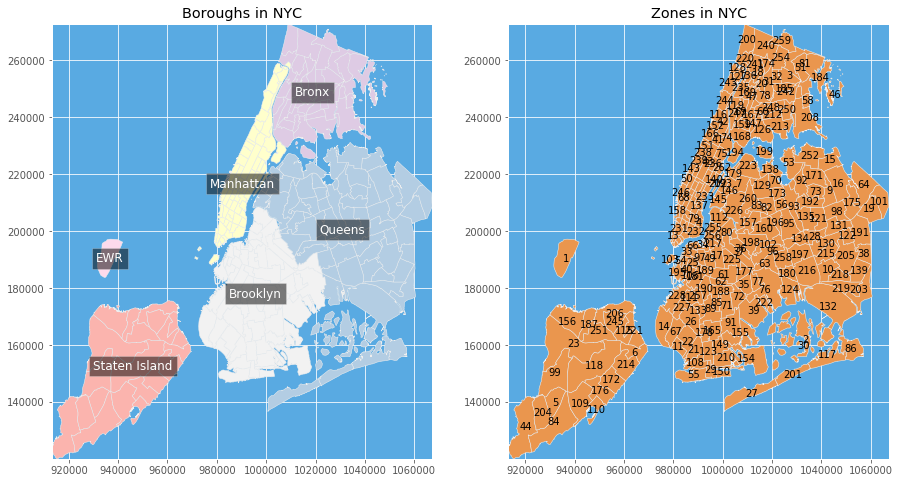

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

# Which zones have most pickups and drop-offs?
Selecting location of pickup/dropoff and their counts from database

In [14]:
df_pu = pd.read_sql_query('SELECT PULocationID AS LocationID, count(*) AS PUcount \
                        FROM yellow_taxi \
                        GROUP BY PULocationID', nyc_database)
df_do = pd.read_sql_query('SELECT DOLocationID AS LocationID, count(*) AS DOcount \
                        FROM yellow_taxi \
                        GROUP BY DOLocationID', nyc_database)


With selected data, we find the zones with most pickups and drop-offs.

In [15]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                    .sort_values(by=['LocationID'])
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))


Table below shows the top 5 zones for 2019

- Top 5 pickup zones are: Upper East Side South, Midtown Center, Upper East Side North, Midtown East, Penn Station/Madison Square West which are all in Manhattan.

- Top 5 drop-off zones are also Upper East Side North, Midtown Center, Upper East Side South, Murray Hill and Times Square/Theatre District also all in Manhattan.

In [16]:
PUtop5 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(5)
PUtop5

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
237.0,3451728.0,3086341.0,6538069.0,Upper East Side South,Manhattan
161.0,3255357.0,3086726.0,6342083.0,Midtown Center,Manhattan
236.0,3113363.0,3242965.0,6356328.0,Upper East Side North,Manhattan
162.0,2875908.0,2414153.0,5290061.0,Midtown East,Manhattan
186.0,2865019.0,2065346.0,4930365.0,Penn Station/Madison Sq West,Manhattan


In [17]:
DOtop5 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(5)
DOtop5

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
236.0,3113363.0,3242965.0,6356328.0,Upper East Side North,Manhattan
161.0,3255357.0,3086726.0,6342083.0,Midtown Center,Manhattan
237.0,3451728.0,3086341.0,6538069.0,Upper East Side South,Manhattan
170.0,2459304.0,2497068.0,4956372.0,Murray Hill,Manhattan
230.0,2741224.0,2464141.0,5205365.0,Times Sq/Theatre District,Manhattan


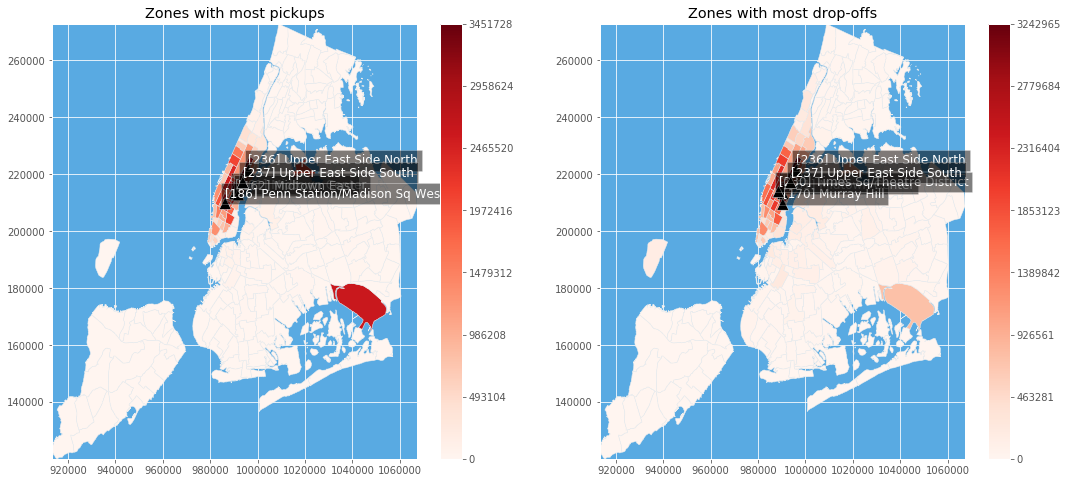

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop5.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop5.index.tolist())

From the figures above, we can see that despite the top 5 pickup/dropoff zones, many other zones in Manhattan are also popular.  

The zone in the lower-right corner that shows quite high number of demans is Queens, where JFK Airport is located. JFK is ranked at 7th pick-up location and 38th drop-off location among top 50 zones. La Guardia Air port ranks at the 14th in pick-up locations and 35th in drop-off locations. Rest of top 50 zones were in Manhattan. 

So I investigated boroughs with most pickups and drop-offs. In the tables below, we can see that Manhattan is obviously the most popular borough and Staten Island is the least popular borough. Queens and Brooklyn are also popular, although their pickup/droppoff count is less than 10% of Manhattan’s. This could be due to "Green Taxi", which are allowed to pick up passengers in northern Manhattan (north of West 110th street and East 96th street), and anywhere in the Bronx, Brooklyn, Staten Island and Queens (excluding the airports).

In [48]:
df_q1_region = df_q1.groupby(["borough"], as_index=False) \
                    .agg({'PUcount': 'sum', 'DOcount': 'sum', 'TOTALcount': 'sum'}) \
                    .sort_values(by=['TOTALcount'], ascending=False)
df_q1_region

,borough,PUcount,DOcount,TOTALcount
3,Manhattan,72353067.0,70602688.0,142955755.0
4,Queens,5596103.0,4313760.0,9909863.0
1,Brooklyn,942218.0,3300853.0,4243071.0
0,Bronx,142466.0,555199.0,697665.0
2,EWR,8324.0,167541.0,175865.0
5,Staten Island,3365.0,21833.0,25198.0


In [49]:
PUcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['PUcount'].tolist()))
DOcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['DOcount'].tolist()))

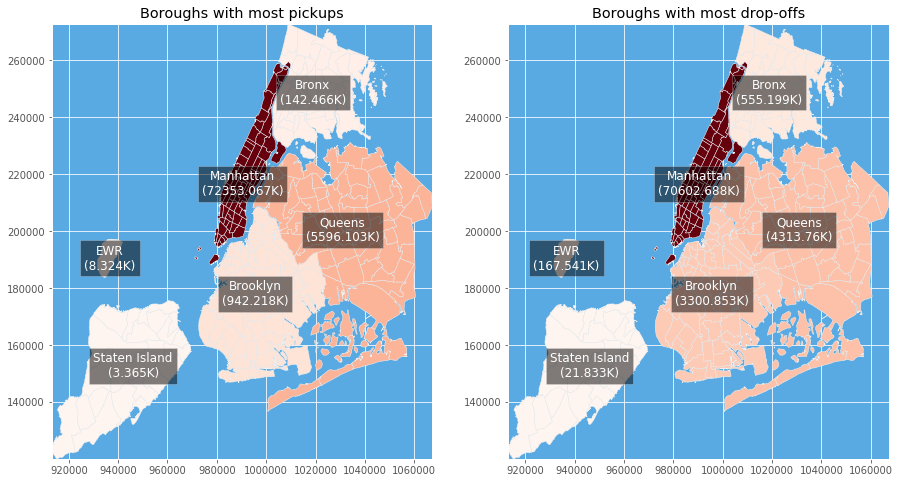

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, sf, heat = PUcount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, sf, heat = DOcount)

# Note to self: FVHHV should be investigated to see if their trips are in and out of further locations



# Peak hours and Off hours

Selecting hours of pickup/dropoff and their counts from database

In [60]:
df_pu = pd.read_sql_query('SELECT pickup_hour AS time, count(*) AS PUcount \
                        FROM yellow_taxi \
                        GROUP BY pickup_hour', nyc_database)
df_do = pd.read_sql_query('SELECT dropoff_hour AS time, count(*) AS DOcount \
                        FROM yellow_taxi \
                        GROUP BY dropoff_hour', nyc_database)
df_q2 = df_pu.merge(df_do, on="time")

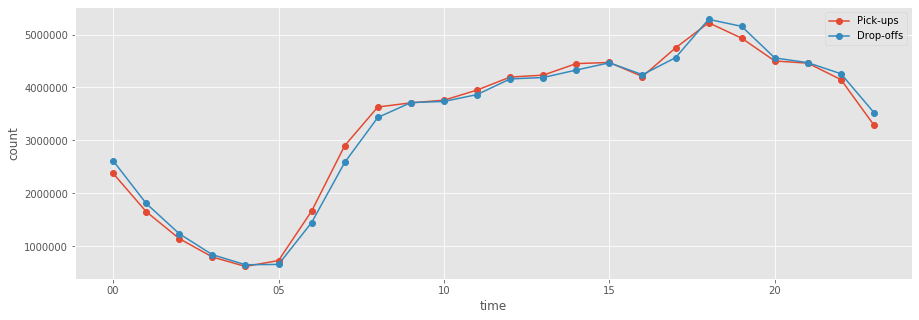

In [63]:
template = pd.DataFrame(["{0:0=2d}".format(x) for x in range(0,24)], columns=["time"])
df_q2 = df_q2.join(template.set_index("time"), how = 'outer', on=["time"]).fillna(0) \
                .groupby(["time"], as_index=False) \
                .agg({'PUcount': 'sum', 'DOcount': 'sum'}) \
                .rename(columns = {'PUcount':'Pick-ups', 'DOcount': 'Drop-offs'}) \
                .sort_values(by='time')

ax = df_q2.plot(x='time', y=['Pick-ups', 'Drop-offs'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
plt.show()


As shown in the figure above, 

- Peak hour is 6PM
- Off hour is 4AM
- Active hours are from 7AM to 11PM



# Trip Distance

To get a closer look at the distribution of trip distance, we select the trip_distance column values and print out its summary statistics.


In [43]:
df_dist = pd.read_sql_query('SELECT trip_distance FROM Yellow_Taxi WHERE trip_distance > 0', nyc_database)
df_dist['trip_distance'].describe()


count    7.910166e+07
mean     3.031037e+00
std      6.846007e+00
min      1.000000e-02
25%      1.000000e+00
50%      1.650000e+00
75%      3.090000e+00
max      4.597722e+04
Name: trip_distance, dtype: float64

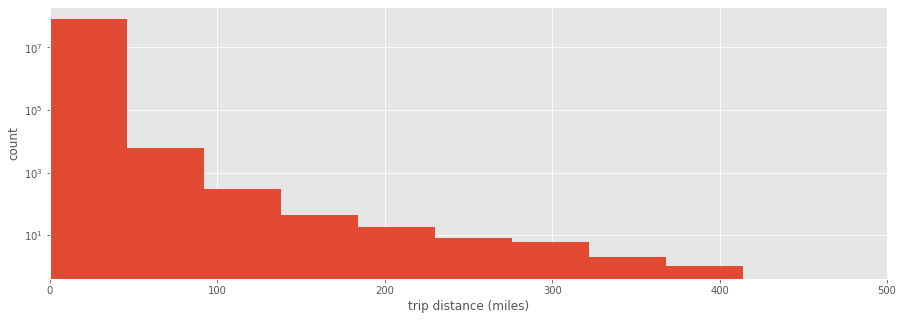

In [44]:
ax = df_dist['trip_distance'].hist(bins=1000, figsize=(15,5))
ax.set_yscale('log')
ax.set_xlim(0, 500)
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
plt.show()

## Short vs Long distance

The distribution of trip_distance is extremely right skewed as shown in the figure above. As there were some extreme outliers, the figure's x limit is set to 500 miles. Y axis is set at log scale.


Considering that the landmass of New York City is 302.6 square miles, the figure above should represent most trips taking place within the area. Now, total area of Manhattan is 33.58 square miles. That number should let us split the trips into short and long distance groups.  

In [61]:
df_dist_short = df_dist[df_dist['trip_distance'] < 34]
df_dist_long = df_dist[df_dist['trip_distance'] >= 34]

print("Short Trips: {} records in total. \nLong Trips: {} records in total."
     .format(len(df_dist_short), len(df_dist_long)))

Short Trips: 79077239 records in total. 
Long Trips: 24423 records in total.


More than 99% of trips are short distance trips. 

Fare price... how much is long distance?
Uber Air is $5 per mile
Taxi Fare Manhattan $59(Newark, JFK), $49(LaGuardia)
distance: jfk(14.1 miles), LGA(5.1 miles), Newark(12.4 miles)

Uber Air's initial launch

# Trip Duration as well

df[trip_duration] = drop off time - pick up time


In [62]:
df_time = pd.read_sql_query('SELECT tpep_pickup_datetime, tpep_dropoff_datetime\
                        FROM yellow_taxi', nyc_database)

# need distance too in order to calculate time for each distance
# will also need fair to calculate

In [63]:
df_time.head()

,tpep_pickup_datetime,tpep_dropoff_datetime
0,2019-01-01 00:46:40,2019-01-01 00:53:20
1,2019-01-01 00:59:47,2019-01-01 01:18:59
2,2018-12-21 13:48:30,2018-12-21 13:52:40
3,2018-11-28 15:52:25,2018-11-28 15:55:45
4,2018-11-28 15:56:57,2018-11-28 15:58:33


In [72]:
test = df_time.head()


In [73]:
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
test['tpep_dropoff_datetime'] = pd.to_datetime(test['tpep_dropoff_datetime'])



/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
test['trip_duration'] = test['tpep_dropoff_datetime']-test['tpep_pickup_datetime']
test

/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration
0,2019-01-01 00:46:40,2019-01-01 00:53:20,00:06:40
1,2019-01-01 00:59:47,2019-01-01 01:18:59,00:19:12
2,2018-12-21 13:48:30,2018-12-21 13:52:40,00:04:10
3,2018-11-28 15:52:25,2018-11-28 15:55:45,00:03:20
4,2018-11-28 15:56:57,2018-11-28 15:58:33,00:01:36


In [77]:
df_pu.head()

,LocationID,PUcount
0,NaN,1
1,1.0,8324
2,2.0,100
3,3.0,1906
4,4.0,134598


In [79]:
df_do.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocationID  263 non-null    float64
 1   DOcount     264 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 4.2 KB


## Observe the difference in temporal attributes

Uber Air would be better suited to serve long distance. Here we observe the difference in temporal attributes for both short and long distances.

In [80]:
df_q3_short = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM yellow_taxi \
                                 WHERE trip_distance < 34 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)

df_q3_long = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM yellow_taxi \
                                 WHERE trip_distance >= 34 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)
